In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
os.listdir('../input/ranzcr-clip-catheter-line-classification/')

['train_tfrecords',
 'sample_submission.csv',
 'train_annotations.csv',
 'test_tfrecords',
 'train.csv',
 'test',
 'train']

In [3]:
train = pd.read_csv('../input/ranzcr-clip-catheter-line-classification/train.csv')
test = pd.read_csv('../input/ranzcr-clip-catheter-line-classification/sample_submission.csv')
train_annotations = pd.read_csv('../input/ranzcr-clip-catheter-line-classification/train_annotations.csv')

# delete suspicious data
train = train[train['StudyInstanceUID'] != '1.2.826.0.1.3680043.8.498.93345761486297843389996628528592497280'].reset_index(drop=True)
train_annotations = train_annotations[train_annotations['StudyInstanceUID'] != '1.2.826.0.1.3680043.8.498.93345761486297843389996628528592497280'].reset_index(drop=True)

## Directory settings

In [4]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

#TRAIN_PATH = '../input/ranzcr-512x512-dataset'
# TRAIN_PATH = '../input/ranzcr-640x640-dataset'
TRAIN_PATH = '../input/ranzcr-clip-catheter-line-classification/train'

## CFG

In [5]:
# ======================================================
# CFG 
# ======================================================
class CFG:
    debug=False
    print_freq=100
    num_workers=4
    model_name='tf_efficientnet_b3_ns'
    size=512
    scheduler='CosineAnnealingLR'
    epochs=6
    #factor=0.2 # ReduceLROnPlateau
    #patience=4 # ReduceLROnPlateau
    #eps=1e-6 # ReduceLROnPlateau
    T_max=6 # CosineAnnealingLR
    #T_0=6 # CosineAnnealingWarmRestarts
    lr=1e-4
    min_lr=1e-6
    batch_size=32
    weight_decay=1e-6
    gradient_accumulation_step=1
    max_grad_norm= 1000
    seed=42
    target_size=11
    target_cols=['ETT - Abnormal', 'ETT - Borderline', 'ETT - Normal',
                 'NGT - Abnormal', 'NGT - Borderline', 'NGT - Incompletely Imaged', 'NGT - Normal', 
                 'CVC - Abnormal', 'CVC - Borderline', 'CVC - Normal',
                 'Swan Ganz Catheter Present']
    n_fold=4
    trn_fold=[0]
    train=True
    
if CFG.debug:
    CFG.epochs = 3
    train = train.sample(n=3000, random_state=CFG.seed).reset_index(drop=True)

## Library

In [6]:
# ======================================================
# Library
# ======================================================
import sys
sys.path.append('../input/pytorch-image-models/')

import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from albumentations import (
    Compose, OneOf, Normalize, Resize, RandomResizedCrop, RandomCrop, HorizontalFlip, VerticalFlip, 
    RandomBrightness, RandomContrast, RandomBrightnessContrast, Rotate, ShiftScaleRotate, Cutout, 
    IAAAdditiveGaussianNoise, Transpose
    )
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

import timm

from torch.cuda.amp import autocast, GradScaler

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Utils

In [7]:
# ===================================================
# Utils
# ===================================================
def get_score(y_true, y_pred):
    scores = []
    for i in range(y_true.shape[1]):
        score = roc_auc_score(y_true[:, i], y_pred[:, i])
        scores.append(score)
    avg_score = np.mean(scores)
    return avg_score, scores

@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f}s.')
    
def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()

def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed_torch(seed=42)

## CV split

In [8]:
folds = train.copy()
Fold = GroupKFold(n_splits=CFG.n_fold)
groups = folds['PatientID'].values
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG.target_cols], groups)):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
display(folds.groupby('fold').size())

fold
0    7521
1    7521
2    7520
3    7520
dtype: int64

## Dataset

In [9]:
# ======================================================
# Dataset
# ======================================================
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['StudyInstanceUID'].values
        self.labels = df[CFG.target_cols].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{TRAIN_PATH}/{file_name}.jpg'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        label = torch.tensor(self.labels[idx]).float()
        return image, label

## Transforms

In [10]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):
    
    if data == 'train':
        return Compose([
            Resize(CFG.size, CFG.size), 
            RandomResizedCrop(CFG.size, CFG.size, scale=(0.85, 1.0)), 
            HorizontalFlip(p=0.5), 
            Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
            ), 
            ToTensorV2(),
        ])
    
    elif data == 'valid':
        return Compose( [
            Resize(CFG.size, CFG.size), 
            Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
            ), 
            ToTensorV2(),
            
        ])

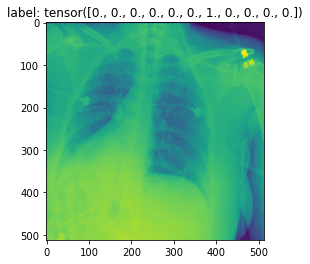

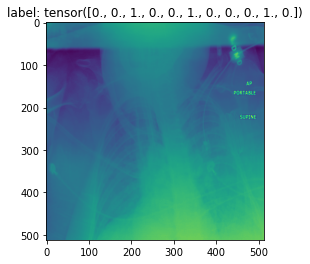

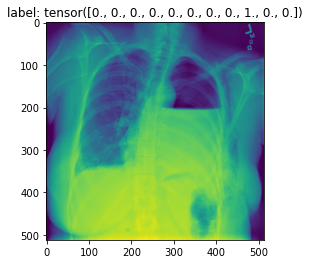

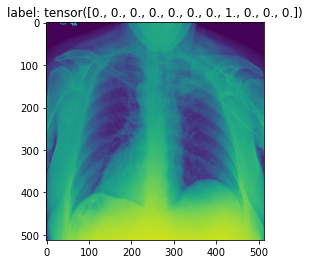

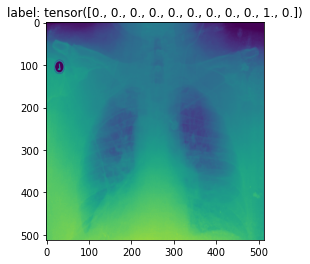

In [11]:
train_dataset = TrainDataset(train, transform=get_transforms(data='train'))

for i in range(5):
    image, label = train_dataset[i]
    plt.imshow(image[0])
    plt.title(f'label: {label}')
    plt.show()

In [12]:
# =================================================
# MODEL
# =================================================
class CustomEfficientNet(nn.Module):
    def __init__(self, model_name='tf_efficientnet_b3_ns', pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, CFG.target_size)
        
    def forward(self, x):
        x = self.model(x)
        return x

In [13]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / percent
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    scaler = GradScaler()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # msasure data loading time 
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with autocast():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_step > 1:
            loss = loss / CFG.gradient_accumulation_steps
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_step == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  #'LR: {lr:.6f}  '
                  .format(
                   epoch+1, step, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   #lr=scheduler.get_lr()[0],
                   ))
    return losses.avg

def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evalutation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = label.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        if CFG.gradient_accumulation_step > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   step, len(valid_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(valid_loader)),
                   ))
    predictions = np.concatenate(preds)
    return losses.avg, predictions

In [14]:
# ===================================================
# Train loop
# ===================================================
def train_loop(folds, fold):
    
    LOGGER.info(f"========== fold: {fold} training ==========")
    
    # =========================================================
    # loader
    # =========================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index
    
    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)
    valid_labels = valid_folds[CFG.target_cols].values
    
    train_dataset = TrainDataset(train_folds, transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, transform=get_transforms(data='valid'))
    
    train_loader = DataLoader(train_dataset, 
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers,
                              pin_memory=True, 
                              drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size * 2, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, 
                              pin_memory=True, 
                              drop_last=False)
    
    # =====================================================
    # scheduler
    # =====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler
    
    # =====================================================
    # model & optimizer
    # =====================================================
    model = CustomEfficientNet(CFG.model_name, pretrained=True)
    model.to(device)
    
    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)
    
    # =====================================================
    # loop
    # =====================================================
    criterion = nn.BCEWithLogitsLoss()
    
    best_score = 0.
    best_loss = np.inf
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)
        
        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()
        
        # scoreing
        score, scores = get_score(valid_labels, preds)
        
        elapsed = time.time() - start_time
        
        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f} avg_val_loss: {avg_val_loss:.4f} time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f} Scores: {np.round(scores, decimals=4)}')
        
        """
        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
        """
        
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds}, 
                       OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
            
        # save all models
        torch.save({'model': model.state_dict()}, 
                   OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_epoch{epoch+1}.pth')
            
    check_point = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
    for c in [f'pred_{c}' for c in CFG.target_cols]:
        valid_folds[c] = np.nan
    valid_folds[[f'pred_{c}' for c in CFG.target_cols]] = check_point['preds']
    
    return valid_folds

In [15]:
# =====================================================
# main
# =====================================================
def main():
    """
    Prepare: 1.train 2.folds
    """
    
    def get_result(result_df):
        preds = result_df[[f'pred_{c}' for c in CFG.target_cols]].values
        labels = result_df[CFG.target_cols].values
        score, scores = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f} Scores: {np.round(scores, decimals=4)}')
        
    if CFG.train:
        # train
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(folds, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f'========== fold: {fold} result ==========')
                get_result(_oof_df)
        
        # CV result
        LOGGER.info(f'========== CV ==========')
        get_result(oof_df)
        # save result
        oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)

In [16]:
if __name__ == '__main__':
    main()

========== fold: 0 training ==========
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b3_ns-9d44bf68.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b3_ns-9d44bf68.pth


Epoch: [1][0/705] Data 6.486 (6.486) Elapsed 0m 8s (remain 104m 38s) Loss: 0.6965(0.6965) Grad: 28203.5762  
Epoch: [1][100/705] Data 1.579 (0.462) Elapsed 2m 51s (remain 17m 7s) Loss: 0.2197(0.3480) Grad: 16192.0205  
Epoch: [1][200/705] Data 0.166 (0.424) Elapsed 5m 33s (remain 13m 55s) Loss: 0.2216(0.2905) Grad: 12728.2012  
Epoch: [1][300/705] Data 0.005 (0.427) Elapsed 8m 18s (remain 11m 8s) Loss: 0.1931(0.2681) Grad: 9081.1543  
Epoch: [1][400/705] Data 0.003 (0.430) Elapsed 11m 1s (remain 8m 21s) Loss: 0.2560(0.2573) Grad: 27003.9863  
Epoch: [1][500/705] Data 1.370 (0.431) Elapsed 13m 46s (remain 5m 36s) Loss: 0.1564(0.2493) Grad: 20719.4844  
Epoch: [1][600/705] Data 0.000 (0.424) Elapsed 16m 26s (remain 2m 50s) Loss: 0.2174(0.2428) Grad: 21176.6387  
Epoch: [1][700/705] Data 0.852 (0.422) Elapsed 19m 9s (remain 0m 6s) Loss: 0.1997(0.2379) Grad: 21984.3691  
Epoch: [1][704/705] Data 0.000 (0.420) Elapsed 19m 13s (remain 0m 0s) Loss: 0.2708(0.2377) Grad: 17520.8027  
EVAL: [0/1

Epoch 1 - avg_train_loss: 0.2377 avg_val_loss: 0.2121 time: 1493s
Epoch 1 - Score: 0.8262 Scores: [0.877  0.9044 0.9847 0.8602 0.8446 0.9546 0.9552 0.617  0.6115 0.5846
 0.8946]
Epoch 1 - Save Best Loss: 0.2121 Model


EVAL: [117/118] Data 0.000 (2.345) Elapsed 5m 39s (remain 0m 0s) Loss: 0.2235(0.2121) 
Epoch: [2][0/705] Data 6.522 (6.522) Elapsed 0m 7s (remain 91m 2s) Loss: 0.1949(0.1949) Grad: 18195.4297  
Epoch: [2][100/705] Data 1.403 (0.434) Elapsed 2m 47s (remain 16m 41s) Loss: 0.2030(0.2017) Grad: 19162.6602  
Epoch: [2][200/705] Data 0.000 (0.418) Elapsed 5m 29s (remain 13m 47s) Loss: 0.2294(0.1996) Grad: 24630.5312  
Epoch: [2][300/705] Data 0.010 (0.413) Elapsed 8m 11s (remain 10m 59s) Loss: 0.2111(0.1977) Grad: 25982.9629  
Epoch: [2][400/705] Data 0.000 (0.411) Elapsed 10m 51s (remain 8m 14s) Loss: 0.1496(0.1930) Grad: 15773.9385  
Epoch: [2][500/705] Data 1.049 (0.404) Elapsed 13m 31s (remain 5m 30s) Loss: 0.1566(0.1901) Grad: 23300.2637  
Epoch: [2][600/705] Data 0.604 (0.399) Elapsed 16m 10s (remain 2m 47s) Loss: 0.1751(0.1882) Grad: 32740.7266  
Epoch: [2][700/705] Data 0.270 (0.396) Elapsed 18m 50s (remain 0m 6s) Loss: 0.1221(0.1855) Grad: 26571.6914  
Epoch: [2][704/705] Data 0.000

Epoch 2 - avg_train_loss: 0.1854 avg_val_loss: 0.1765 time: 1470s
Epoch 2 - Score: 0.8964 Scores: [0.9008 0.9255 0.9862 0.8537 0.8883 0.964  0.9668 0.8111 0.7502 0.8181
 0.9957]
Epoch 2 - Save Best Loss: 0.1765 Model


EVAL: [117/118] Data 0.000 (2.322) Elapsed 5m 35s (remain 0m 0s) Loss: 0.1619(0.1765) 
Epoch: [3][0/705] Data 5.474 (5.474) Elapsed 0m 6s (remain 78m 59s) Loss: 0.2345(0.2345) Grad: 23568.2129  
Epoch: [3][100/705] Data 1.974 (0.454) Elapsed 2m 49s (remain 16m 52s) Loss: 0.1390(0.1598) Grad: 26688.1562  
Epoch: [3][200/705] Data 2.394 (0.435) Elapsed 5m 34s (remain 13m 58s) Loss: 0.1197(0.1598) Grad: 23601.1250  
Epoch: [3][300/705] Data 1.700 (0.426) Elapsed 8m 16s (remain 11m 6s) Loss: 0.1440(0.1591) Grad: 39511.0508  
Epoch: [3][400/705] Data 1.790 (0.425) Elapsed 11m 2s (remain 8m 22s) Loss: 0.1148(0.1574) Grad: 25235.6074  
Epoch: [3][500/705] Data 1.756 (0.422) Elapsed 13m 45s (remain 5m 36s) Loss: 0.1861(0.1565) Grad: 34363.4688  
Epoch: [3][600/705] Data 1.919 (0.424) Elapsed 16m 29s (remain 2m 51s) Loss: 0.1840(0.1565) Grad: 34980.6562  
Epoch: [3][700/705] Data 0.000 (0.419) Elapsed 19m 9s (remain 0m 6s) Loss: 0.1498(0.1549) Grad: 34541.2188  
Epoch: [3][704/705] Data 0.000 (

Epoch 3 - avg_train_loss: 0.1548 avg_val_loss: 0.1700 time: 1493s
Epoch 3 - Score: 0.9120 Scores: [0.9467 0.9371 0.9877 0.8874 0.8966 0.9623 0.9683 0.8363 0.7719 0.8413
 0.9968]
Epoch 3 - Save Best Loss: 0.1700 Model


EVAL: [117/118] Data 0.000 (2.344) Elapsed 5m 39s (remain 0m 0s) Loss: 0.1401(0.1700) 
Epoch: [4][0/705] Data 6.671 (6.671) Elapsed 0m 7s (remain 92m 51s) Loss: 0.1080(0.1080) Grad: 40448.3672  
Epoch: [4][100/705] Data 0.002 (0.484) Elapsed 2m 52s (remain 17m 14s) Loss: 0.1129(0.1349) Grad: 32531.7695  
Epoch: [4][200/705] Data 0.000 (0.454) Elapsed 5m 38s (remain 14m 8s) Loss: 0.1037(0.1367) Grad: 26362.0801  
Epoch: [4][300/705] Data 0.000 (0.437) Elapsed 8m 20s (remain 11m 11s) Loss: 0.0996(0.1373) Grad: 32373.1074  
Epoch: [4][400/705] Data 0.000 (0.423) Elapsed 11m 0s (remain 8m 20s) Loss: 0.0863(0.1372) Grad: 16019.7646  
Epoch: [4][500/705] Data 0.000 (0.419) Elapsed 13m 42s (remain 5m 35s) Loss: 0.1459(0.1369) Grad: 22591.0098  
Epoch: [4][600/705] Data 0.000 (0.416) Elapsed 16m 24s (remain 2m 50s) Loss: 0.1138(0.1376) Grad: 20911.8242  
Epoch: [4][700/705] Data 0.000 (0.414) Elapsed 19m 7s (remain 0m 6s) Loss: 0.1510(0.1372) Grad: 16764.0566  
Epoch: [4][704/705] Data 0.000 (

Epoch 4 - avg_train_loss: 0.1372 avg_val_loss: 0.1722 time: 1492s
Epoch 4 - Score: 0.9130 Scores: [0.956  0.9337 0.9874 0.8901 0.9024 0.9608 0.9707 0.8422 0.7675 0.8394
 0.9927]


EVAL: [117/118] Data 0.000 (2.347) Elapsed 5m 38s (remain 0m 0s) Loss: 0.1507(0.1722) 
Epoch: [5][0/705] Data 6.082 (6.082) Elapsed 0m 7s (remain 85m 39s) Loss: 0.1220(0.1220) Grad: 38059.1523  
Epoch: [5][100/705] Data 2.035 (0.467) Elapsed 2m 51s (remain 17m 4s) Loss: 0.0806(0.1228) Grad: 30609.5859  
Epoch: [5][200/705] Data 1.281 (0.433) Elapsed 5m 34s (remain 13m 58s) Loss: 0.1373(0.1206) Grad: 46254.0859  
Epoch: [5][300/705] Data 1.124 (0.416) Elapsed 8m 15s (remain 11m 4s) Loss: 0.1472(0.1200) Grad: 29488.2969  
Epoch: [5][400/705] Data 0.000 (0.411) Elapsed 10m 58s (remain 8m 19s) Loss: 0.1442(0.1199) Grad: 43485.0195  
Epoch: [5][500/705] Data 0.003 (0.414) Elapsed 13m 43s (remain 5m 35s) Loss: 0.0950(0.1181) Grad: 32647.3457  
Epoch: [5][600/705] Data 0.000 (0.412) Elapsed 16m 26s (remain 2m 50s) Loss: 0.0811(0.1186) Grad: 72059.5156  
Epoch: [5][700/705] Data 0.000 (0.410) Elapsed 19m 7s (remain 0m 6s) Loss: 0.0780(0.1188) Grad: 39155.0547  
Epoch: [5][704/705] Data 0.000 (

Epoch 5 - avg_train_loss: 0.1187 avg_val_loss: 0.1728 time: 1494s
Epoch 5 - Score: 0.9138 Scores: [0.9445 0.9311 0.9871 0.8969 0.9036 0.9624 0.9685 0.8439 0.7721 0.8499
 0.9921]


EVAL: [117/118] Data 0.000 (2.374) Elapsed 5m 41s (remain 0m 0s) Loss: 0.1626(0.1728) 
Epoch: [6][0/705] Data 5.713 (5.713) Elapsed 0m 6s (remain 81m 45s) Loss: 0.1436(0.1436) Grad: 46062.7344  
Epoch: [6][100/705] Data 1.748 (0.445) Elapsed 2m 49s (remain 16m 51s) Loss: 0.0966(0.1110) Grad: 40377.8008  
Epoch: [6][200/705] Data 1.315 (0.417) Elapsed 5m 30s (remain 13m 48s) Loss: 0.1018(0.1095) Grad: 56066.3555  
Epoch: [6][300/705] Data 2.138 (0.419) Elapsed 8m 14s (remain 11m 4s) Loss: 0.0878(0.1082) Grad: 38034.4297  
Epoch: [6][400/705] Data 1.063 (0.413) Elapsed 10m 56s (remain 8m 17s) Loss: 0.1855(0.1083) Grad: 22899.4941  
Epoch: [6][500/705] Data 1.639 (0.407) Elapsed 13m 36s (remain 5m 32s) Loss: 0.0765(0.1095) Grad: 20990.8574  
Epoch: [6][600/705] Data 1.377 (0.406) Elapsed 16m 19s (remain 2m 49s) Loss: 0.1127(0.1101) Grad: 22007.7559  
Epoch: [6][700/705] Data 0.000 (0.402) Elapsed 18m 58s (remain 0m 6s) Loss: 0.0880(0.1094) Grad: 19865.3652  
Epoch: [6][704/705] Data 0.000

Epoch 6 - avg_train_loss: 0.1093 avg_val_loss: 0.1750 time: 1480s
Epoch 6 - Score: 0.9136 Scores: [0.9429 0.9308 0.9868 0.8981 0.904  0.9641 0.9669 0.8422 0.7746 0.8464
 0.9922]


EVAL: [117/118] Data 0.000 (2.338) Elapsed 5m 37s (remain 0m 0s) Loss: 0.1668(0.1750) 


========== fold: 0 result ==========
Score: 0.9120 Scores: [0.9467 0.9371 0.9877 0.8874 0.8966 0.9623 0.9683 0.8363 0.7719 0.8413
 0.9968]
========== CV ==========
Score: 0.9120 Scores: [0.9467 0.9371 0.9877 0.8874 0.8966 0.9623 0.9683 0.8363 0.7719 0.8413
 0.9968]
